## 1. Import Required Libraries

In [ ]:
import os
import sys
import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display, Image
import glob
import re

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")
print(f"Current working directory: {os.getcwd()}")

✓ All libraries imported successfully
Current working directory: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/water_tommerby_benchmark/notebooks


## 2. Configure Benchmark Parameters

In [14]:
# Data and results paths (relative to project root)
DATA_PATH = "../../processing/tommerby_processing/tommerby_features_engineered_from_2018-04-01.csv"

RESULTS_DIR = "../results"
SCRIPTS_DIR = "../scripts"

# ========================================
# MODELS TO BENCHMARK - Choose strategy:
# ========================================
# Option 1: All models in one job (may take 20-25 hours)
# MODELS_TO_RUN = ["NHITS_Q", "NHITS_MSE", "TIMESNET_Q", "TIMESNET_MSE", "TFT_Q", "TFT_MSE"]

# Option 2: Split by architecture (RECOMMENDED - run jobs in parallel or sequentially)
# Job 1: Quantile models (~10-15 hours)
MODELS_TO_RUN = ["NHITS_MSE","TIMESNET_MSE"]

# Job 2: MSE models (~10-15 hours) - Change to this and run cell 3 again
# MODELS_TO_RUN = ["NHITS_MSE", "TIMESNET_MSE", "TFT_MSE"]

# SLURM job configuration
SLURM_SCRIPT = "../scripts/benchmark_water_job.slurm"
JOB_ID_FILE = "../scripts/current_job_id.txt"

# Verify data file exists
if os.path.exists(DATA_PATH):
    print(f"✓ Data file found: {DATA_PATH}")
    df_info = pd.read_csv(DATA_PATH, nrows=5)
    print(f"  Columns: {list(df_info.columns[:5])}... (total: {len(df_info.columns)})")
    print(f"  Target: water_consumption")
else:
    print(f"✗ Data file not found: {DATA_PATH}")
    
# Create results directory if needed
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"✓ Results directory ready: {RESULTS_DIR}")
print(f"✓ Benchmarking models: {', '.join(MODELS_TO_RUN)}")
print(f"\n💡 Strategy: Split submission - run Quantile models first, then MSE models")
print(f"   Available models: NHITS_Q, NHITS_MSE, TIMESNET_Q, TIMESNET_MSE, TFT_Q, TFT_MSE")

✓ Data file found: ../../processing/tommerby_processing/tommerby_features_engineered_from_2018-04-01.csv
  Columns: ['timestamp', 'water_consumption', 'temp', 'dew_point', 'humidity']... (total: 27)
  Target: water_consumption
✓ Results directory ready: ../results
✓ Benchmarking models: NHITS_MSE, TIMESNET_MSE

💡 Strategy: Split submission - run Quantile models first, then MSE models
   Available models: NHITS_Q, NHITS_MSE, TIMESNET_Q, TIMESNET_MSE, TFT_Q, TFT_MSE


## 3. Submit SLURM Benchmark Job

**RECOMMENDED**: Submit to SLURM for full benchmarking on GPU

In [3]:
# Submit benchmarker to SLURM
print("Submitting water benchmarker job to SLURM...")
print(f"Models to run: {', '.join(MODELS_TO_RUN)}")
print(f"Script: {SLURM_SCRIPT}")

# Convert models list to space-separated string for shell argument
models_arg = " ".join(MODELS_TO_RUN)

result = subprocess.run(
    ["sbatch", SLURM_SCRIPT, models_arg],
    capture_output=True,
    text=True,
    cwd="../scripts"
)

if result.returncode == 0:
    # Extract job ID from output: "Submitted batch job 123456"
    job_id = result.stdout.strip().split()[-1]
    print(f"\n✓ Job submitted successfully!")
    print(f"  Job ID: {job_id}")
    print(f"  Models: {', '.join(MODELS_TO_RUN)}")
    print(f"  Log files: {SCRIPTS_DIR}/benchmark_{job_id}.log / benchmark_{job_id}.err")
    print(f"\n💡 Next: Run cell below to monitor job status")
    
    # Save job ID for monitoring
    with open(JOB_ID_FILE, "w") as f:
        f.write(job_id)
else:
    print(f"✗ Error submitting job:\n{result.stderr}")

Submitting water benchmarker job to SLURM...
Models to run: NHITS_MSE, TIMESNET_MSE
Script: ../scripts/benchmark_water_job.slurm

✓ Job submitted successfully!
  Job ID: 1482193
  Models: NHITS_MSE, TIMESNET_MSE
  Log files: ../scripts/benchmark_1482193.log / benchmark_1482193.err

💡 Next: Run cell below to monitor job status


## 4. Monitor Job Status

Check if the benchmarker job is running or complete.

In [3]:
# Check SLURM job status
if os.path.exists(JOB_ID_FILE):
    with open(JOB_ID_FILE, "r") as f:
        job_id = f.read().strip()
else:
    print("❌ No job ID found. Run cell above to submit the job.")
    job_id = None

if job_id:
    print(f"Checking status of Job {job_id}...")
    print("="*70)
    
    # Check with squeue
    result = subprocess.run(
        ["squeue", "-j", job_id, "--format=%.18i %.9P %.20j %.8u %.8T %.10M %.9l %.6D %R"],
        capture_output=True,
        text=True
    )
    
    if "Invalid job id" in result.stderr or not result.stdout.strip().split('\n')[1:]:
        print(f"⏹️  Job {job_id} is no longer in queue (completed or failed)")
        
        # Check if results exist
        results_file = pattern = os.path.join(RESULTS_DIR, f"benchmark_results_*_Water_Centrum_{job_id}.csv")
        matches = glob.glob(results_file)
        
        # Use the first match (or matches[0] if you expect multiple)
        results_file = matches[0]
        print(f"File found: {results_file}")

        if matches:
            # Use the first match (or matches[0] if you expect multiple)
            results_file = matches[0]
            print(f"File found: {results_file}")
            
            # 3. Open the file
            df = pd.read_csv(results_file)
        else:
            print(f"No file found for JobID: {jobid}")

        if os.path.exists(results_file):
            print(f"\n✅ Job completed successfully!")
            print(f"   Results file found: {results_file}")
            print(f"\n💡 Next: Continue to next cell to view results")
        else:
            print(f"\n❌ Job completed but results not found!")
            print(f"   Check log files: {SCRIPTS_DIR}/benchmark_{job_id}.log")
    else:
        print(result.stdout)
        print(f"\n⏳ Job is still running. Re-run this cell to check again.")
        print(f"   Estimated time: ~2-3 hours for all 4 models")
        
    # Show recent log output
    log_file = f"{SCRIPTS_DIR}/benchmark_{job_id}.log"
    if os.path.exists(log_file):
        print(f"\n📄 Recent log output (last 15 lines):")
        print("-"*70)
        result = subprocess.run(["tail", "-n", "15", log_file], capture_output=True, text=True)
        print(result.stdout)

Checking status of Job 1482193...
⏹️  Job 1482193 is no longer in queue (completed or failed)


IndexError: list index out of range

## 5. Display Benchmark Results

Load and display the comprehensive metrics comparison.

In [15]:
# Load and display latest results
import glob

# Find the latest timestamped results file
results_pattern = os.path.join(RESULTS_DIR, "benchmark_results_*_Water_Centrum_*.csv")
result_files = sorted(glob.glob(results_pattern))

if not result_files:
    print("❌ ERROR: No benchmark results found!")
    print(f"   Searched for: {results_pattern}")
    print("\n💡 Solution:")
    print("   - Check cell above to see if job is still running")
    print("   - If job completed, check log files for errors")
else:
    # Load the most recent results file
    latest_results_file = result_files[-1]
    results_df = pd.read_csv(latest_results_file)
    
    print(f"\n📊 WATER CONSUMPTION BENCHMARK RESULTS")
    print(f"Loaded from: {os.path.basename(latest_results_file)}")
    print("="*70)
    display(results_df)
    
    # Highlight best performer for each metric
    print("\n🏆 Best Performer by Metric:")
    for metric in ['MAE', 'RMSE', 'MAPE', 'MIW', 'CRPS']:
        if metric in results_df.columns:
            best_model = results_df.loc[results_df[metric].idxmin(), 'Model']
            best_value = results_df[metric].min()
            print(f"  {metric:8s}: {best_model:12s} ({best_value:.4f})")
    
    # For PICP, closer to 80% is better
    if 'PICP' in results_df.columns:
        target_picp = 80.0
        results_df['PICP_diff'] = (results_df['PICP'] - target_picp).abs()
        best_model = results_df.loc[results_df['PICP_diff'].idxmin(), 'Model']
        best_value = results_df.loc[results_df['PICP_diff'].idxmin(), 'PICP']
        print(f"  PICP    : {best_model:12s} ({best_value:.2f}% - closest to 80%)")

❌ ERROR: No benchmark results found!
   Searched for: ../results/benchmark_results_*_Water_Centrum_*.csv

💡 Solution:
   - Check cell above to see if job is still running
   - If job completed, check log files for errors


## 6. Generate Visualizations

Create comprehensive visualizations comparing all models.

In [16]:
# Generate visualizations using dataset-specific results folder
print("Generating visualizations...")

# Call visualize_benchmark.py with the dataset-specific results folder
result = subprocess.run(
    ["python3", "../../visualize_benchmark.py", os.path.abspath(RESULTS_DIR)],
    capture_output=True,
    text=True
)

print(result.stdout)
if result.returncode == 0:
    print("✓ Visualizations generated successfully!")
else:
    print(f"✗ Error generating visualizations:\n{result.stderr}")

Generating visualizations...
Visualizing results from: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/water_tommerby_benchmark/results
Loading NHITS_Q from: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/water_tommerby_benchmark/results/NHITS_Q_predictions_1481682.csv
Loading TIMESNET_Q from: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/water_tommerby_benchmark/results/TIMESNET_Q_predictions_1481707.csv
Loading TFT_Q from: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/water_tommerby_benchmark/results/TFT_Q_predictions_1481708.csv
Loading NHITS_MSE from: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/water_tommerby_benchmark/results/NHITS_MSE_predictions_1482193.csv
Loading TIMESNET_MSE from: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/water_tommerby_benchmark/results/TIMESNET_MSE_predictions_1482193.csv
File not found for TFT_MSE in /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis/water_tommerby_benchmark/results

Model Comparison Metrics:
                MAE   RMSE    MAPE  MAPE_E

### 6.1 Metrics Comparison Bar Plots

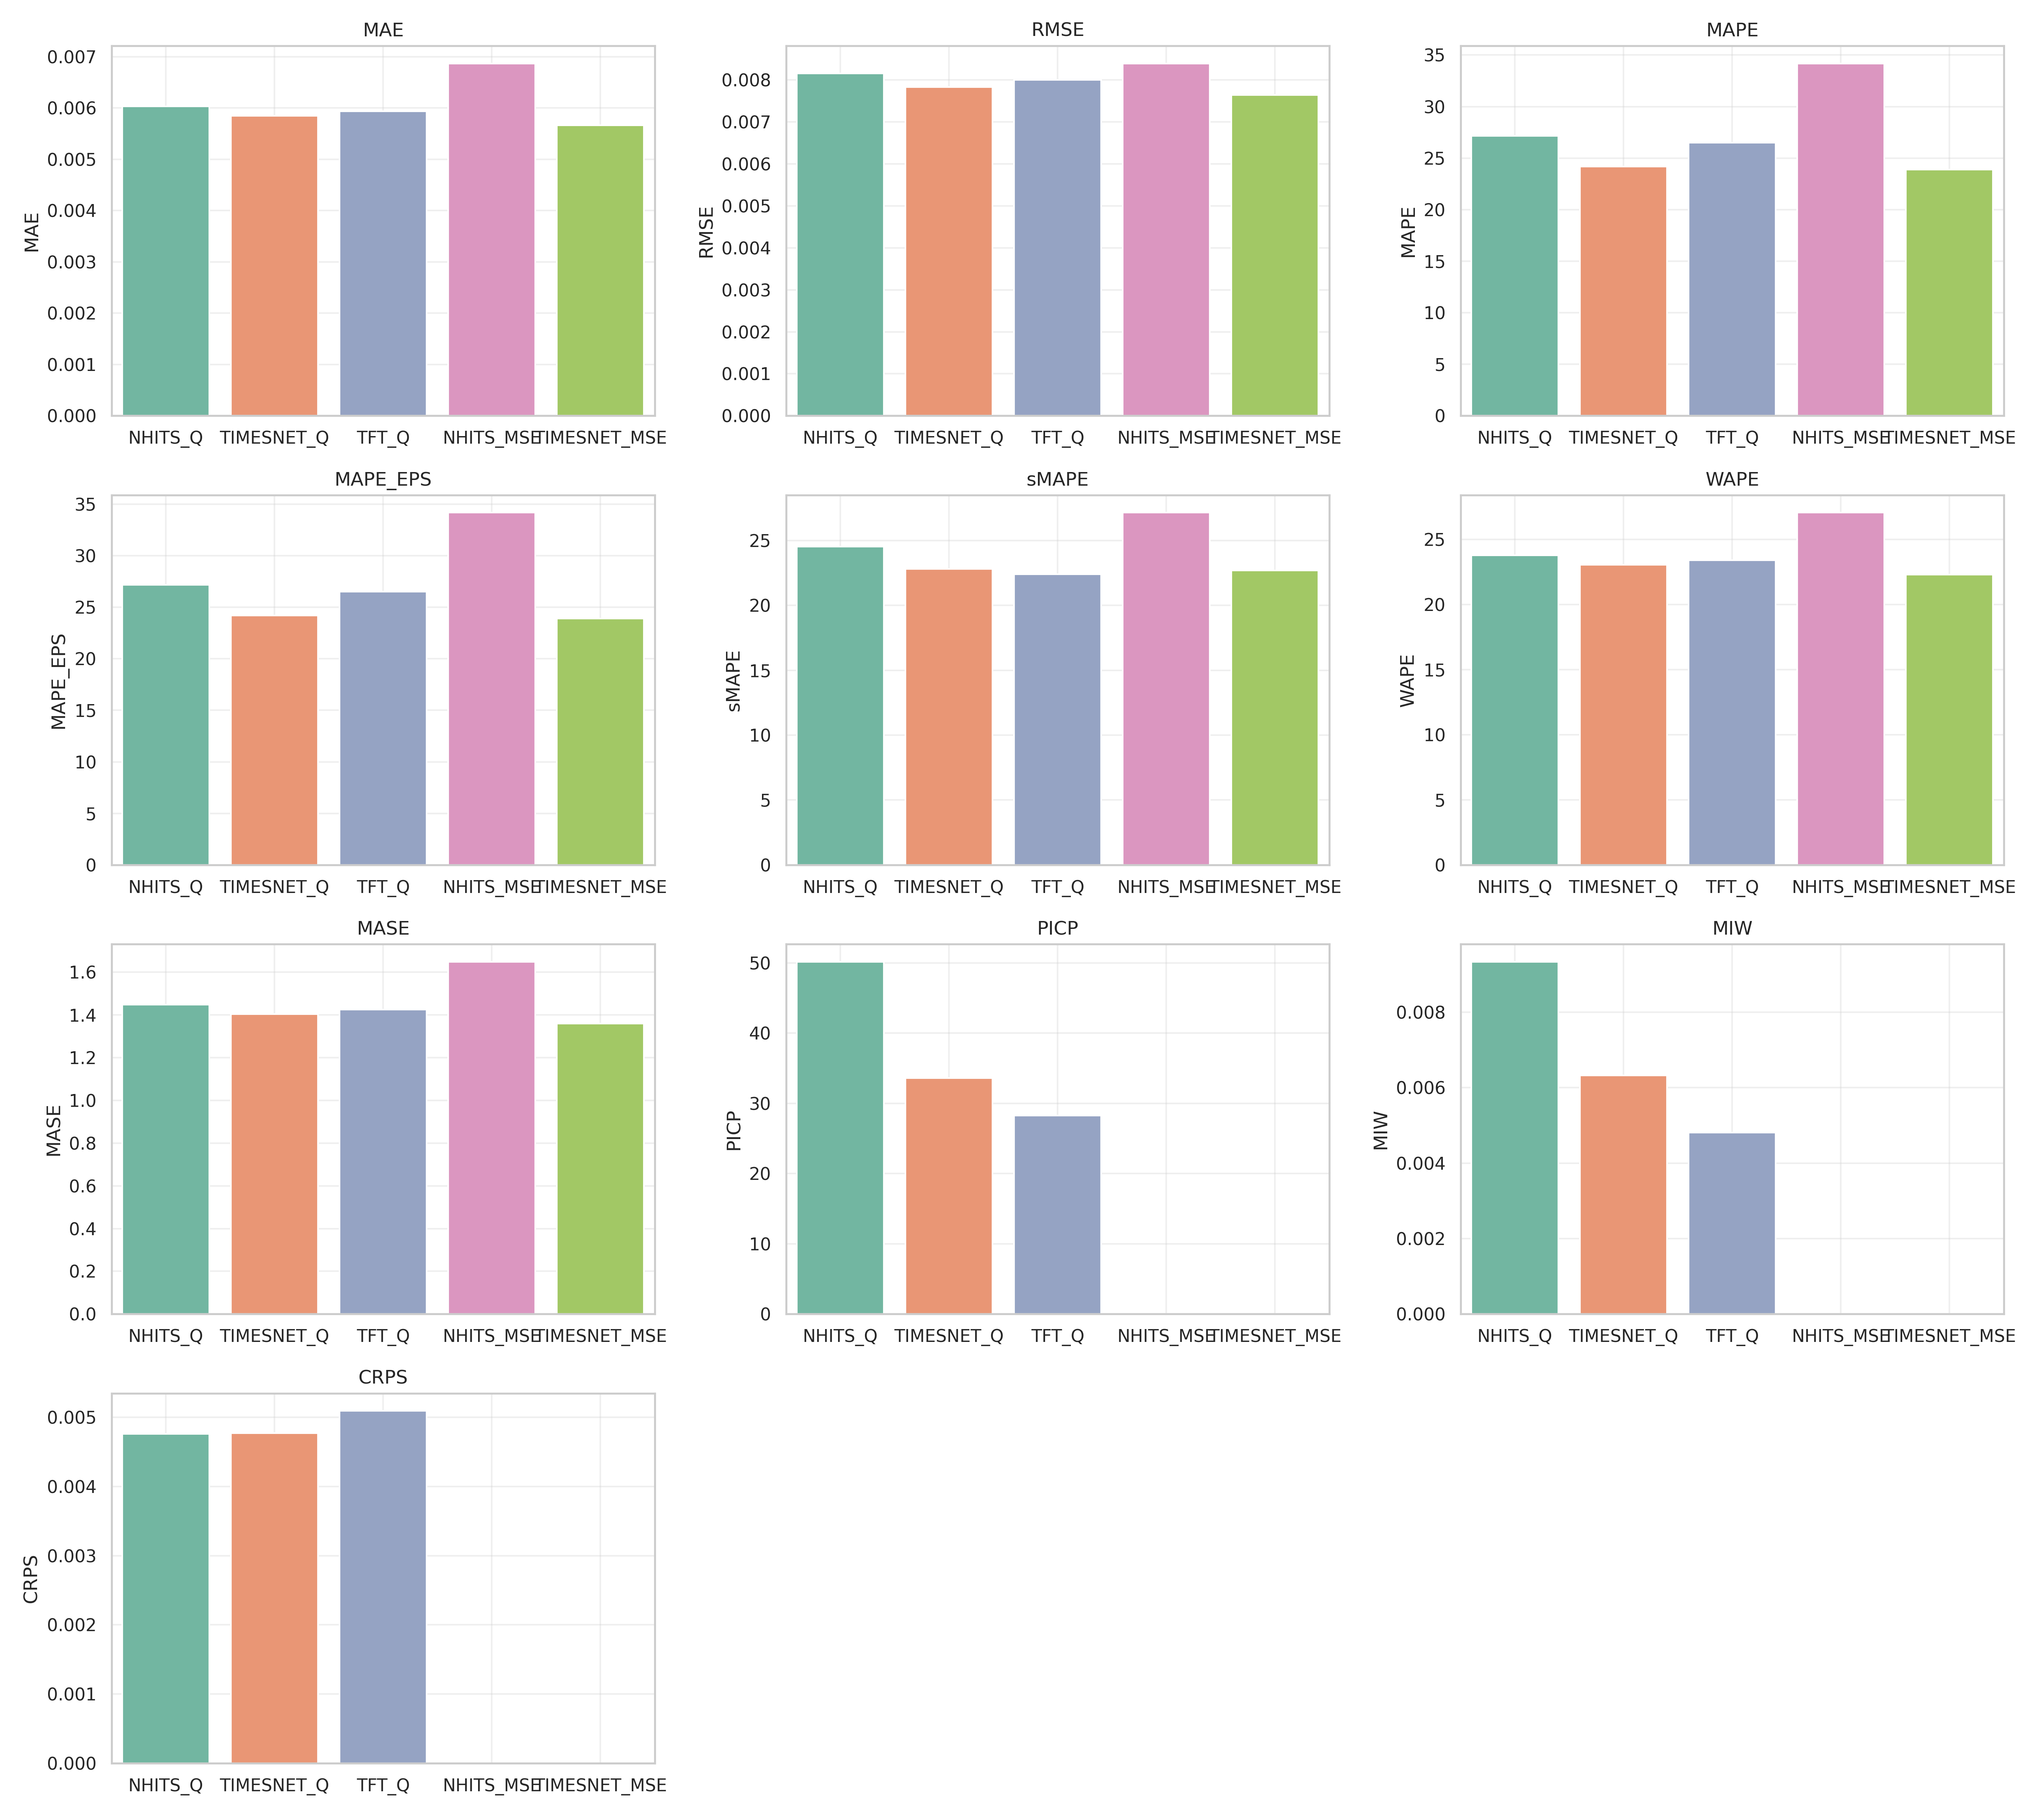

In [17]:
metrics_plot = os.path.join(RESULTS_DIR, "benchmark_metrics_barplots.png")
if os.path.exists(metrics_plot):
    display(Image(filename=metrics_plot))
else:
    print(f"Plot not found: {metrics_plot}")

### 6.2 Box Plots - Prediction Distributions

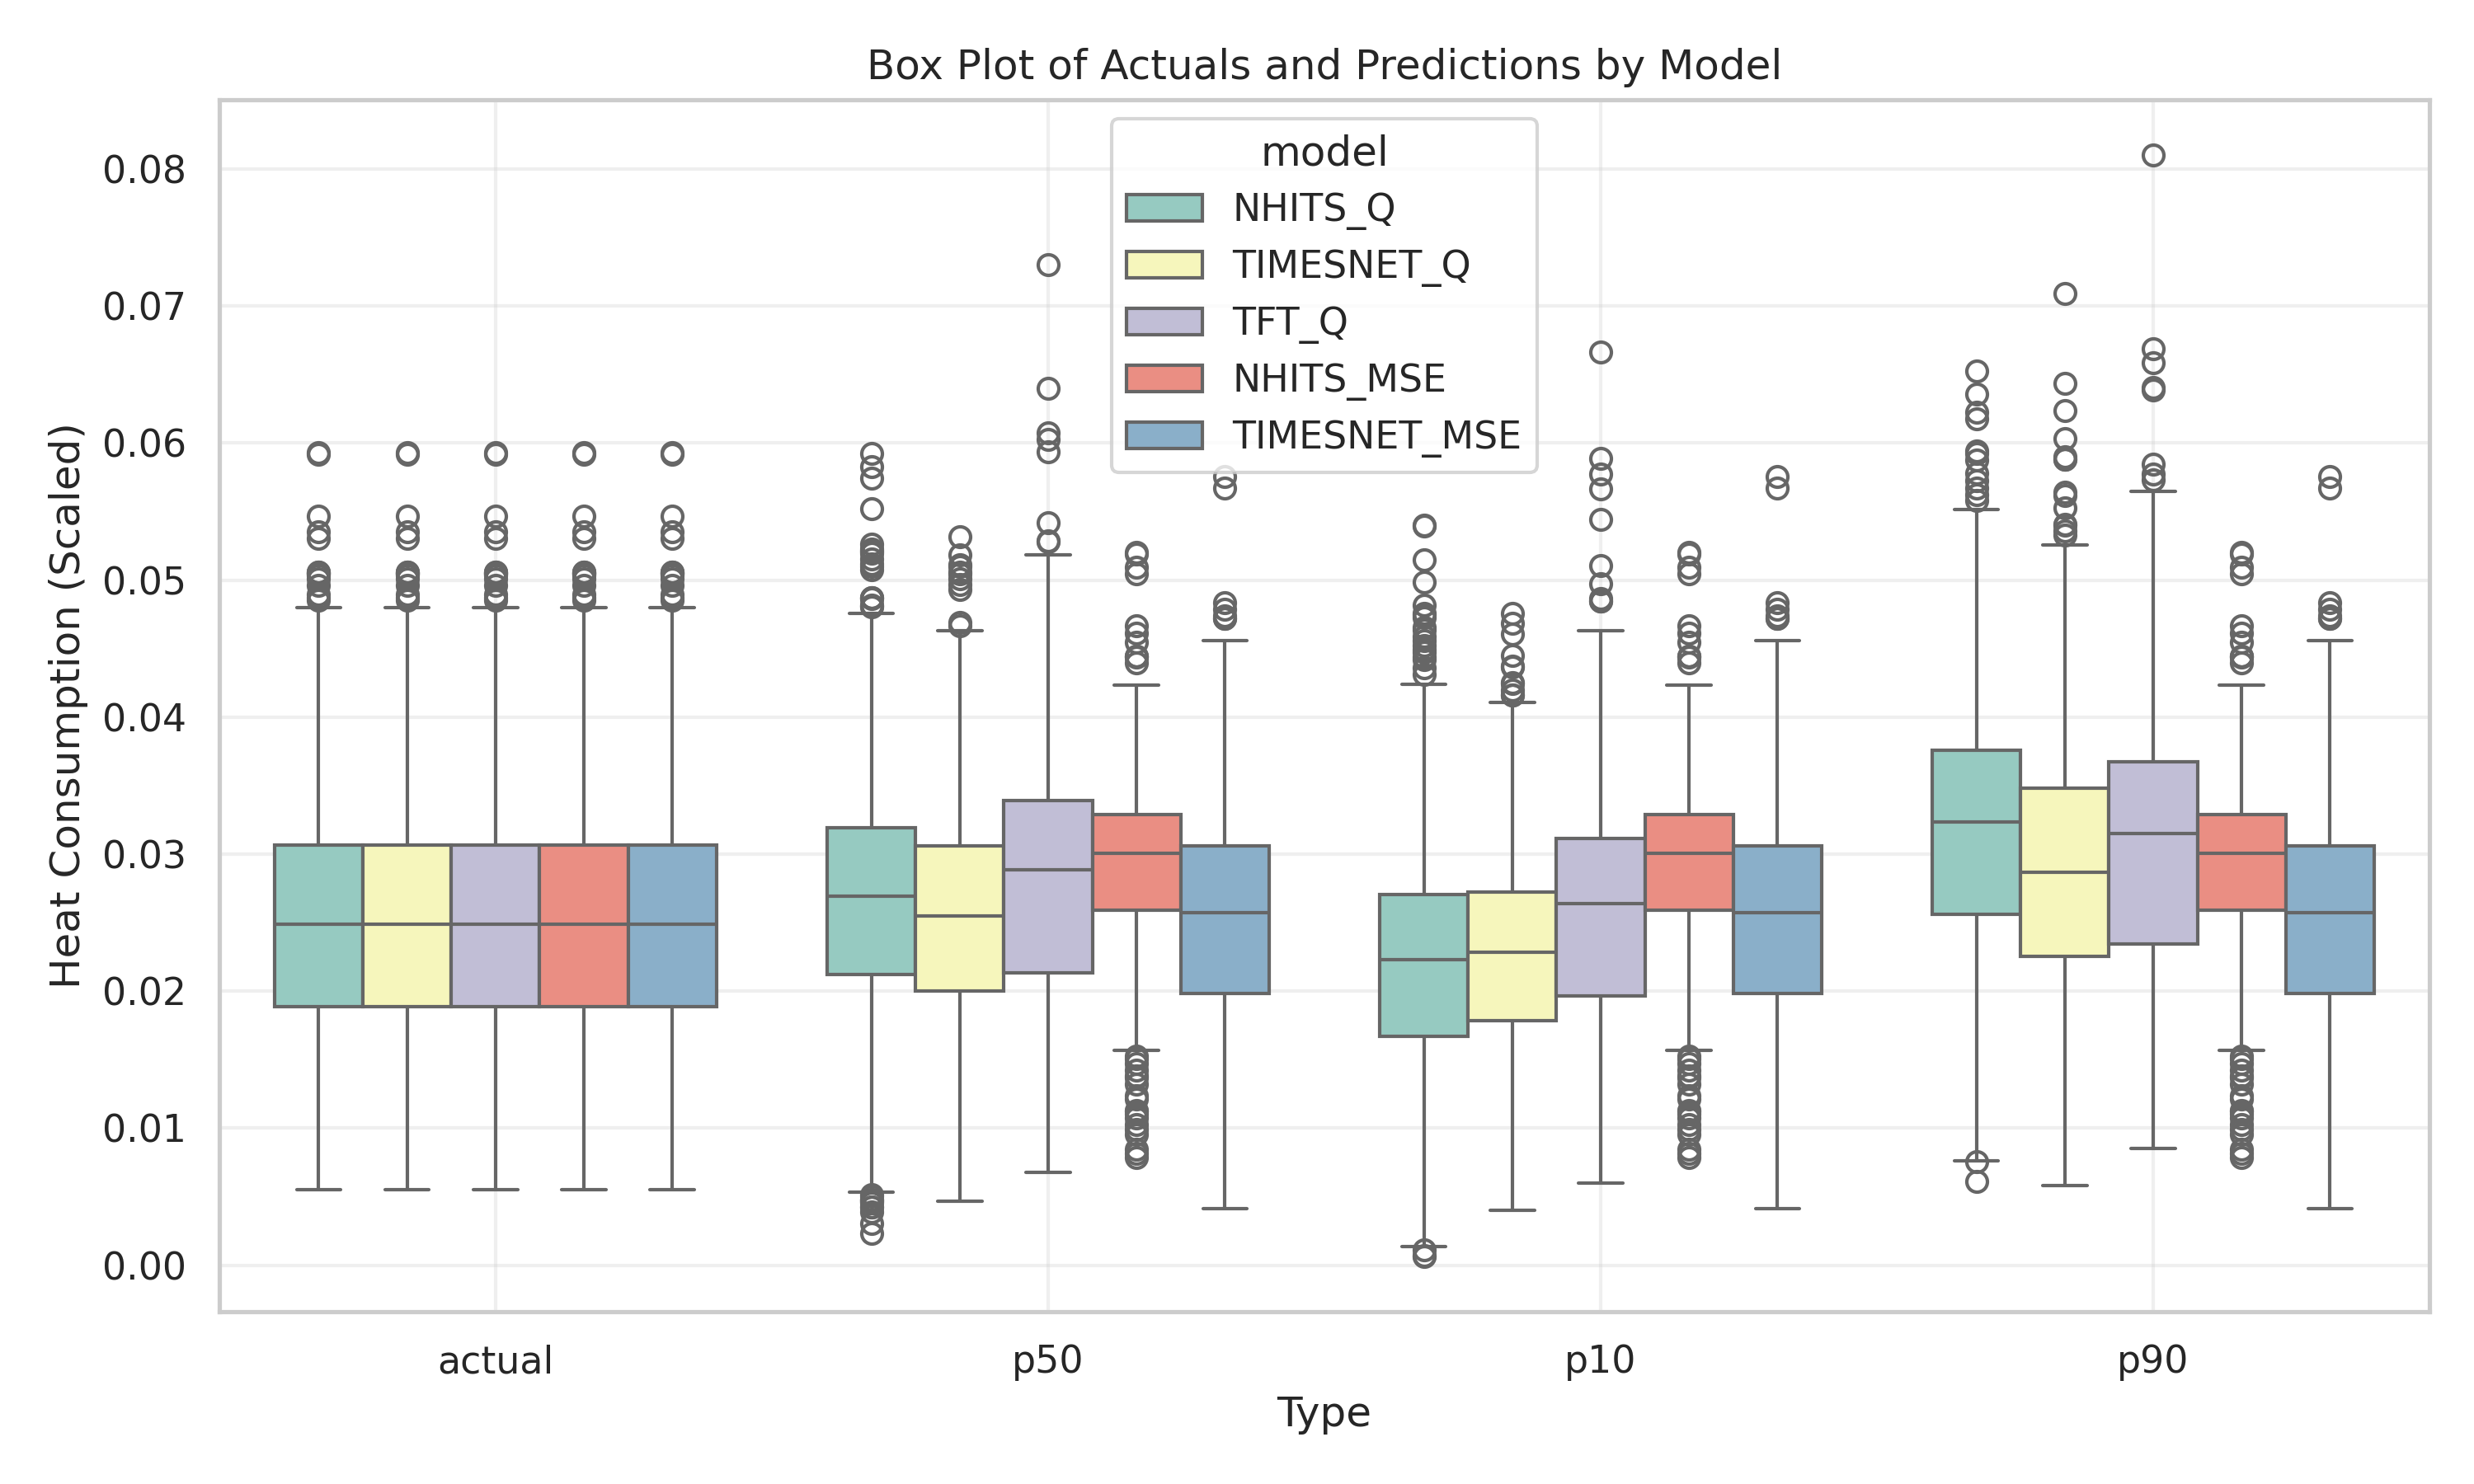

In [19]:
boxplot_img = os.path.join(RESULTS_DIR, "benchmark_boxplots.png")
if os.path.exists(boxplot_img):
    display(Image(filename=boxplot_img))
else:
    print(f"Plot not found: {boxplot_img}")

### 6.3 Side-by-Side Time Series Comparison

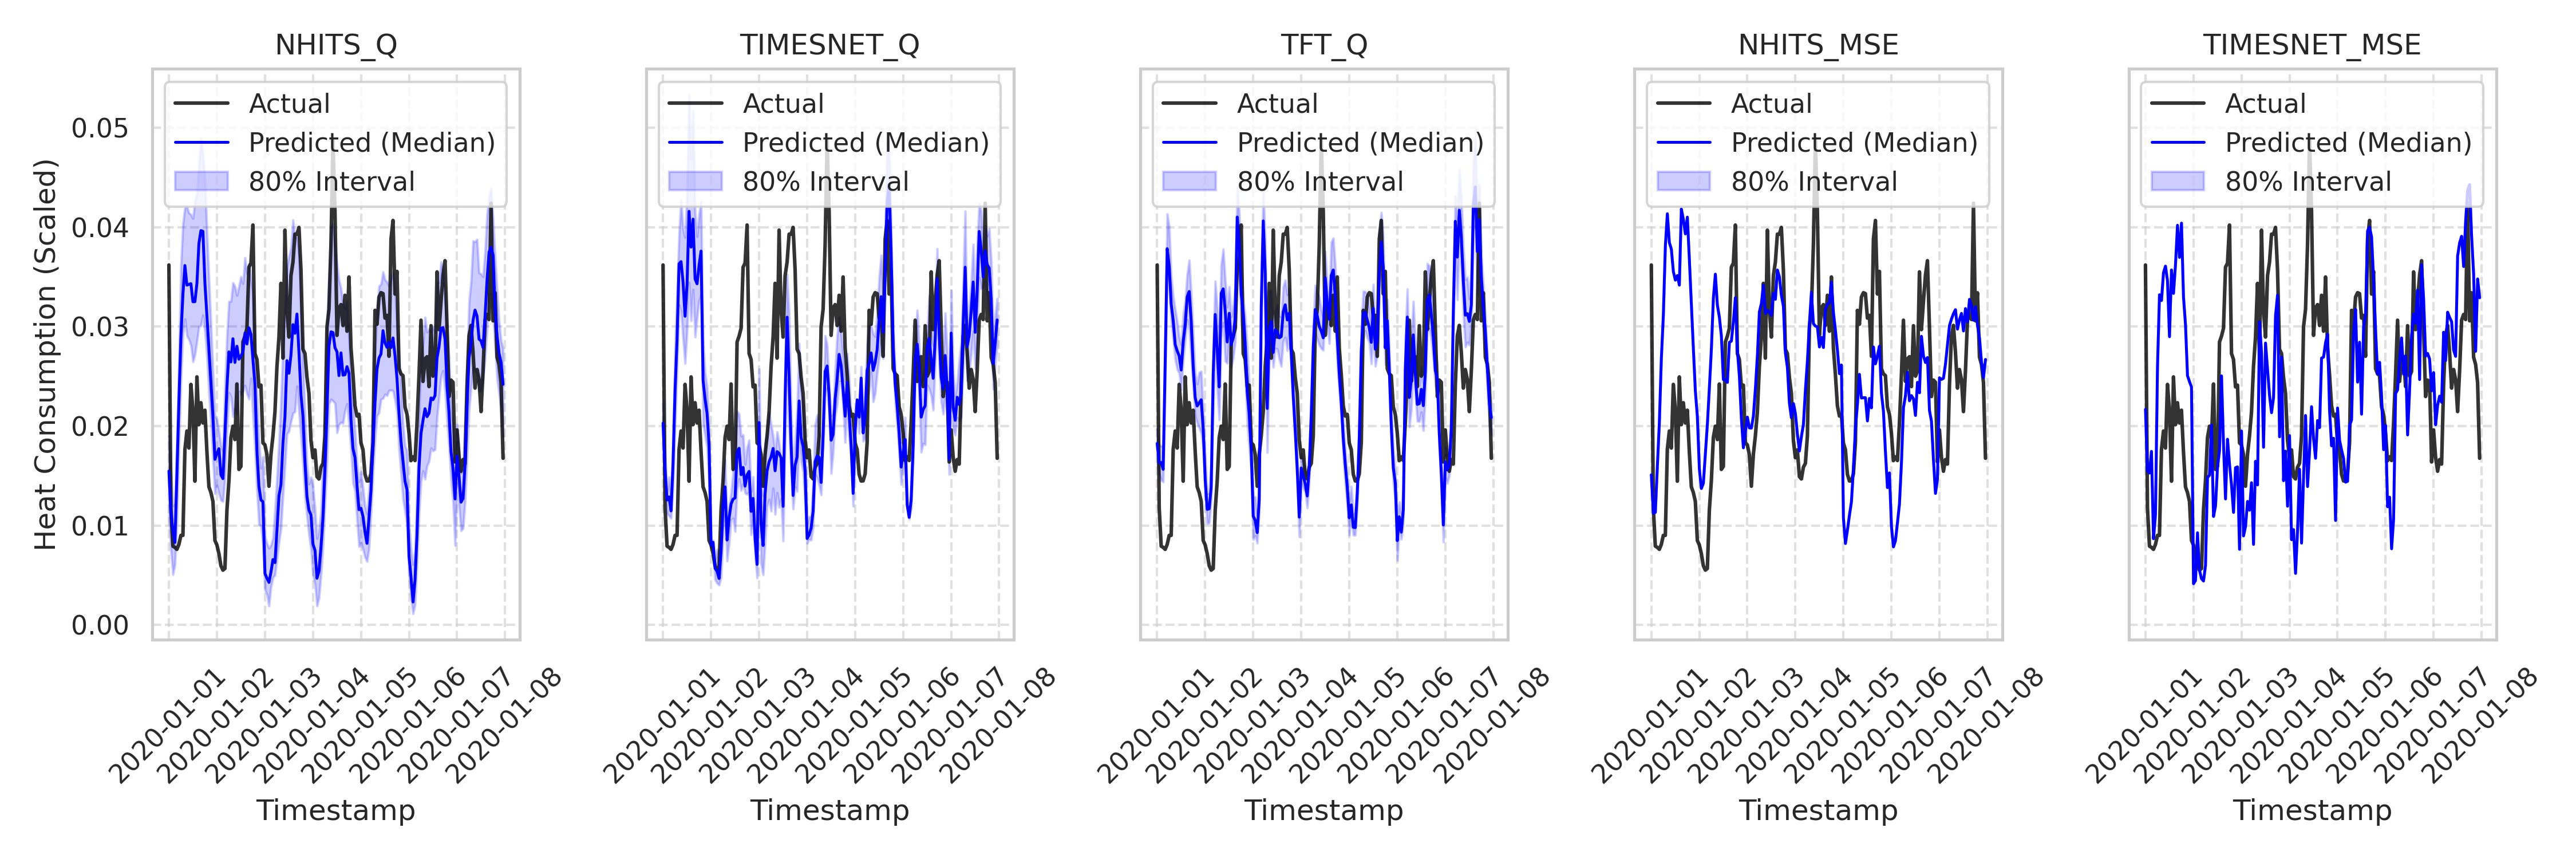

In [20]:
sidebyside_img = os.path.join(RESULTS_DIR, "benchmark_comparison_sidebyside.png")
if os.path.exists(sidebyside_img):
    display(Image(filename=sidebyside_img))
else:
    print(f"Plot not found: {sidebyside_img}")

## 7. View Benchmark History

Track improvements over multiple runs.

In [21]:
# # View benchmark history across all runs for WATER dataset
# history_file = "../../results/benchmark_history.csv"

# if os.path.exists(history_file):
#     history = pd.read_csv(history_file)
    
#     # Filter for water dataset only
#     water_history = history[history['dataset'] == 'Water (Centrum)']
    
#     if len(water_history) == 0:
#         print("❌ No water benchmark history found yet.")
#         print("   Run a benchmark first to start tracking results.")
#     else:
#         print("📊 WATER BENCHMARK HISTORY - ALL RUNS")
#         print("="*70)
#         print(f"Total runs recorded: {len(water_history)}")
#         print(f"Models tracked: {', '.join(water_history['Model'].unique())}")
#         print("\n" + "="*70)
        
#         # Show all runs with key metrics
#         display_cols = ['run_date', 'Model', 'n_epochs', 'has_hpo', 'MAE', 'RMSE', 'MAPE', 'CRPS']
#         available_cols = [col for col in display_cols if col in water_history.columns]
#         display(water_history[available_cols].sort_values('run_date', ascending=False))
        
#         # Show best results ever
#         print("\n🏆 BEST RESULTS EVER ACHIEVED")
#         print("="*70)
#         for model in water_history['Model'].unique():
#             model_history = water_history[water_history['Model'] == model]
#             print(f"\n{model}:")
#             for metric in ['MAE', 'RMSE', 'MAPE', 'CRPS']:
#                 if metric in model_history.columns:
#                     best_idx = model_history[metric].idxmin()
#                     best_val = model_history.loc[best_idx, metric]
#                     best_date = model_history.loc[best_idx, 'run_date']
#                     print(f"  {metric:8s}: {best_val:.4f} (achieved on {best_date})")
# else:
#     print("❌ No benchmark history found.")
#     print(f"   Expected file: {history_file}")

#     print("\n💡 Run a benchmark first to start tracking results.")

In [22]:
pd.read_csv(os.path.join(RESULTS_DIR,"benchmark_metrics_comparison.csv"))

,Unnamed: 0,MAE,RMSE,MAPE,MAPE_EPS,sMAPE,WAPE,MASE,PICP,MIW,CRPS
0,NHITS_Q,0.006033,0.008158,27.171653,27.171653,24.520397,23.775737,1.448482,50.166667,0.009336,0.004762
1,TIMESNET_Q,0.005848,0.007828,24.183687,24.183687,22.808084,23.047900,1.404140,33.583333,0.006322,0.004772
2,TFT_Q,0.005935,0.007997,26.509410,26.509410,22.394816,23.390449,1.425009,28.250000,0.004805,0.005093
3,NHITS_MSE,0.006868,0.008393,34.189261,34.189261,27.148877,27.067011,1.648995,0.000000,0.000000,NaN
4,TIMESNET_MSE,0.005658,0.007636,23.902892,23.902892,22.691738,22.300860,1.358629,0.000000,0.000000,NaN


## 8. Summary and Conclusions

### Key Findings:

Compare these results with the heat benchmarking results to analyze domain differences.

**Next Steps:**
- Review individual model plots for detailed error analysis
- Compare with heat benchmark results (in `nordbyen_heat_benchmark/results/`)
- Consider hyperparameter optimization if results need improvement
- Examine specific time periods where models differ significantly